## HTTP and TLS traffic
- Overview of TLS and HTTP endpoints combined
- We have a separate HTTP notebook, but it doesn't capture the TLS connections. We use TLS SNI field to draw a more complete picture.

In [1]:
import pandas as pd
from os.path import dirname, realpath, join, isfile
from nb_utils import (get_ps1_or_ipaddress, read_pcap_fields_from_txts,
                   download_roku_channel_details, ROKU_MACS)

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(16,9)})

In [3]:
ROOT_PROJ_DIR = dirname(dirname(dirname(dirname(realpath('__file__')))))
DATA_DIR = join(ROOT_PROJ_DIR, "data/pcap_analysis/roku-channel-surfer/2018-09-27")
HTTP_REQS_DIR = join(DATA_DIR, "http")
DNS_QUERIES_DIR = join(DATA_DIR, "dns")
HTTP_CSV = join(DATA_DIR, "roku-2018-09-27-requests.csv")
TLS_SNI_CSV = join(DATA_DIR, "roku-2018-09-27-tls-sni.csv")

### Load channel details
- We only channels details to add helper columns to request dataframe
- Once we build and store the request details, we don't actually need to do this

In [4]:
channel_df = download_roku_channel_details()

## Load HTTP request details
- Load the request details from the CSV or build from scratch

In [5]:
req_df = pd.read_csv(HTTP_CSV, sep='\t', encoding='utf-8')
tls_df = pd.read_csv(TLS_SNI_CSV, sep='\t', encoding='utf-8')

In [6]:
req_df.head()

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,req_method,url,channel_name,domain,rank,category
0,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,77,movies-tvs
1,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,77,movies-tvs
2,63344,1538096403,select,1,d8:31:34:22:e6:ff,173.222.212.76,GET,http://comedycentral.mtvnimages.com/uri/mgid:a...,Comedy Central,mtvnimages.com,77,movies-tvs
3,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,77,movies-tvs
4,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,77,movies-tvs


In [7]:
tls_df.head()

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,host,channel_name,rank,category,domain
0,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.45.134.131,api.roku.com,BIO TV,2068,movies-tvs,roku.com
1,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.84.122.195,wwwimg.roku.com,BIO TV,2068,movies-tvs,roku.com
2,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.21.59.215,api.sr.roku.com,BIO TV,2068,movies-tvs,roku.com
3,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.84.122.175,cigars.roku.com,BIO TV,2068,movies-tvs,roku.com
4,145651,1538303764,launch,0,d8:31:34:22:e6:ff,52.84.122.179,cigars.roku.com,BIO TV,2068,movies-tvs,roku.com


In [8]:
df = pd.concat([req_df, tls_df], axis=0, ignore_index=True, sort=False)

### HTTP requests - overview

In [9]:
print "%d requests to %d distinct domains from %s distinct channels" %\
    (len(df), df.domain.nunique(), df.channel_id.nunique())

41214 requests to 810 distinct domains from 1503 distinct channels


### Top domains
- domains contacted by most channels

In [10]:
df.drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
576,roku.com,1187
351,ifood.tv,329
319,google-analytics.com,242
235,doubleclick.net,218
377,irchan.com,183
594,scorecardresearch.com,164
755,vimeo.com,163
629,spotxchange.com,137
756,vimeocdn.com,126
800,yumenetworks.com,115


### Top domains - Kids and family channels

In [11]:
df[df.category == "kids-family"].drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
126,roku.com,389
70,ifood.tv,272
45,doubleclick.net,74
145,spotxchange.com,64
133,scorecardresearch.com,47
182,yumenetworks.com,39
61,google-analytics.com,37
121,ravm.tv,28
148,superawesome.tv,27
172,vimeo.com,24


### Channels contacting the most domains

In [12]:
df_n_domains_by_channel = df.drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_channel.head(10)

,channel_name,rank,# domains
11,8ctave HD,936,61
67,American Cowboy Classics,2267,59
1420,WatchFreeForeignFlix,1100,47
86,AsianCrush,277,43
1417,WatchFreeActionThrillerFlix,738,40
635,Horror Films by Fawesome.tv,983,39
709,KMTV - Watch K-Pop,2185,38
854,Midnight Pulp,315,37
1419,WatchFreeFlix,81,36
1418,WatchFreeDocumentaryFlix,990,33


### Kids and family channels contacting the most domains

In [13]:
df_n_domains_by_kids_channel = df[df.category == "kids-family"].drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_kids_channel.head(10)

,channel_name,rank,# domains
351,Superman 3D,1708,25
397,Toontime TV,1641,22
296,Only Animation TV,3207,21
316,Popcornflix Kids,268,21
61,Cartoon Club LIVE,1570,21
394,Toontime 2,2170,20
43,Blossom,3085,19
335,So Yummy,2637,18
60,Cartoon Club,1637,18
30,BabyFirst Español,1834,17


### Effect of popularity (rank)
- Do popular channels contact more domains?

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


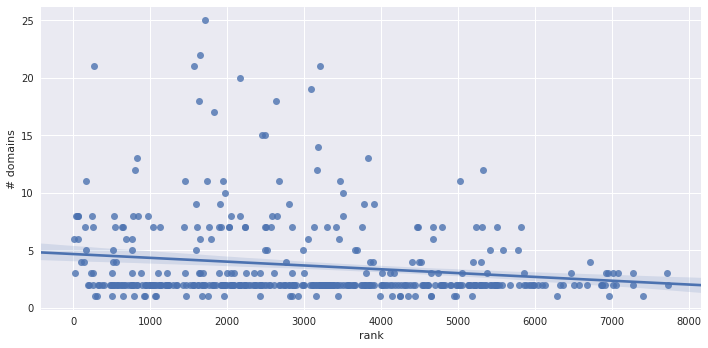

In [14]:
sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_kids_channel, size=5, aspect=2)

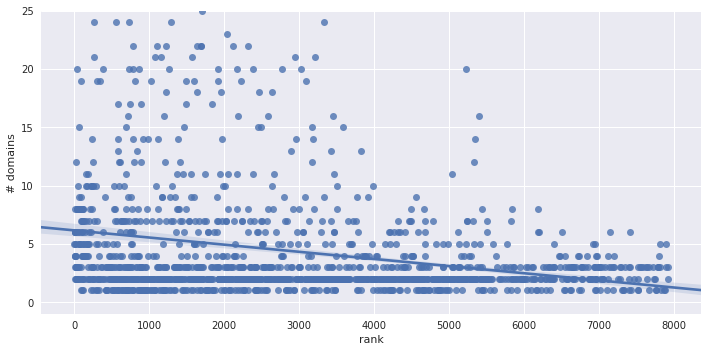

In [15]:
ax = sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_channel, size=5, aspect=2)
ax.set(ylim=(-1, 25))